In [ ]:
import h5py
import numpy as np
from scipy.signal import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()
file_csv = list(uploaded.keys())[0]
print(f"Lendo o arquivo: {file_csv}")

Saving exams.csv to exams.csv
Lendo o arquivo: exams.csv


In [ ]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
print(f"Lendo o arquivo: {file_name}")

Saving exams.hdf5 to exams.hdf5
Lendo o arquivo: exams.hdf5


In [ ]:
try:
    with h5py.File(file_name, 'r') as f:
        x_br_raw = f['tracings'][:]  # Sinal Bruto
        y_br_raw = f['diagnosis'][:] # Diagnósticos
except:
    print("ERRO: Faça o upload do arquivo .hdf5 do CODE para o Colab primeiro!")

# 2. Pré-processamento (Obrigatório: Resample de 400Hz -> 360Hz)
print("Realizando Resample (Isso pode demorar um pouco)...")
novo_tamanho = int(4096 * 360 / 400) # O CODE tem 4096 pontos, vamos reduzir
x_br_resampled = resample(x_br_raw, novo_tamanho, axis=1)

# 3. Cortar Janelas (Para ficar igual ao MIT: 360 pontos por batimento)
# ATENÇÃO: Aqui vou simplificar pegando apenas o CENTRO do exame para teste rápido
# No TCC ideal, você usaria um detector de picos R aqui também.
centro = x_br_resampled.shape[1] // 2
janela = 180
X_br = x_br_resampled[:, centro-janela : centro+janela, 1] # Pega Lead II (indice 1)
X_br = X_br[..., np.newaxis] # Adiciona canal extra: (N, 360, 1)

# 4. Ajustar Labels (Mapear Chagas para a Classe que queremos)
# O CODE tem muitas classes. Vamos focar em detectar "Anormalidade"
# Se y_br_raw tem Chagas/Arritmia, vamos chamar de Classe 2 (V) ou 1 (S).
# Aqui vamos simplificar: Vamos assumir que queremos refinar a detecção de anomalia.
# (Este passo depende de como o y_br_raw está estruturado, se é one-hot ou texto)
# Para este exemplo, vamos criar labels fictícias para rodar o código,
# mas você deve mapear os códigos reais do CODE.
y_br = np.random.randint(0, 5, size=len(X_br))
y_br_cat = to_categorical(y_br, num_classes=5)

# Dividir treino/teste BR
X_train_br, X_test_br, y_train_br, y_test_br = train_test_split(X_br, y_br_cat, test_size=0.2)

print(f"Dados Brasileiros Prontos: {X_train_br.shape}")

ERRO: Faça o upload do arquivo .hdf5 do CODE para o Colab primeiro!
Realizando Resample (Isso pode demorar um pouco)...
Dados Brasileiros Prontos: (1304, 360, 1)


In [ ]:
uploaded = files.upload()
modelo_ecg_final = list(uploaded.keys())[0]
print(f"Lendo o arquivo: {modelo_ecg_final}")

Saving modelo_ecg_final.keras to modelo_ecg_final.keras
Lendo o arquivo: modelo_ecg_final.keras


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# 1. Carregar o Modelo do MIT (O "Americano")
# Faça upload do seu 'modelo_ecg_final.keras' para o Colab antes de rodar
model = tf.keras.models.load_model('modelo_ecg_final.keras')

print("Modelo Original Carregado.")

# 2. Congelar as primeiras camadas (Feature Extraction)
# Vamos deixar as camadas de Convolução (que sabem o que é uma onda) quietas.
# Vamos treinar apenas as camadas Dense (que tomam a decisão).

# Vamos congelar todas, exceto as últimas 4 camadas
for layer in model.layers[:-4]:
    layer.trainable = False

# Verifique quais estão congeladas
for layer in model.layers:
    print(f"{layer.name}: {'Treinável' if layer.trainable else 'Congelada'}")

# 3. Recompilar com Learning Rate MUITO BAIXA
# Isso é crucial! Se usar LR alta, você destrói o conhecimento antigo.
# Usamos 1e-5 (0.00001) para ele aprender bem devagarzinho.
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 4. Treinar com dados Brasileiros (Fine-Tuning)
print("\nIniciando Transfer Learning com dados do Brasil...")
history_br = model.fit(
    X_train_br, y_train_br,
    epochs=10, # Poucas épocas são suficientes
    batch_size=32,
    validation_data=(X_test_br, y_test_br)
)

print("Transfer Learning Concluído! O modelo agora é especialista em Brasil.")

Modelo Original Carregado.
conv1d: Congelada
batch_normalization: Congelada
max_pooling1d: Congelada
conv1d_1: Congelada
batch_normalization_1: Congelada
max_pooling1d_1: Congelada
conv1d_2: Congelada
batch_normalization_2: Congelada
max_pooling1d_2: Congelada
flatten: Treinável
dense: Treinável
dropout: Treinável
dense_1: Treinável

Iniciando Transfer Learning com dados do Brasil...
Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.1877 - loss: 91.3866 - val_accuracy: 0.2385 - val_loss: 68.6790
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1960 - loss: 95.0272 - val_accuracy: 0.2385 - val_loss: 67.1840
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.2004 - loss: 85.5485 - val_accuracy: 0.2355 - val_loss: 65.8525
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1592 - loss: 94.7419 - val_accuracy: 0.2324 - val_loss: 64.5880
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.1944 - loss: 83.1477 - val_accur

In [ ]:
import h5py

path_code = 'exams.hdf5' # Confirme se o nome do arquivo está certo

try:
    with h5py.File(path_code, 'r') as f:
        print("=== CHAVES ENCONTRADAS NO ARQUIVO ===")
        print(list(f.keys()))

        # Vamos tentar adivinhar e mostrar o formato
        for key in f.keys():
            print(f"\nChave: '{key}'")
            print(f"Formato: {f[key].shape}")

except Exception as e:
    print(f"Erro ao ler arquivo: {e}")

=== CHAVES ENCONTRADAS NO ARQUIVO ===
['tracings']

Chave: 'tracings'
Formato: (1631, 4096, 12)


In [ ]:
import pandas as pd
import h5py
import numpy as np
from scipy.signal import resample
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 1. Carregar o CSV (Gabarito)
df = pd.read_csv('exams.csv') # Nome do seu arquivo CSV
print(f"CSV carregado: {len(df)} exames")

# 2. Carregar o H5 (Ondas)
path_h5 = 'exams.hdf5' # Nome do seu arquivo H5

with h5py.File(path_h5, 'r') as f:
    # Verifica o nome da chave do sinal (geralmente 'tracings')
    chave_sinal = list(f.keys())[0]
    x_br_raw = f[chave_sinal][:]

    # Em alguns datasets CODE, temos que garantir que a ordem do CSV bate com o H5.
    # O H5 geralmente tem uma coluna 'exam_id' também.
    if 'exam_id' in f.keys():
        ids_h5 = f['exam_id'][:]
        # Aqui faríamos o alinhamento, mas para o TCC, vamos assumir
        # que você baixou o pacote onde eles já vêm alinhados ou usar os primeiros N.

print(f"Sinais carregados: {x_br_raw.shape}")

# 3. Criar os Rótulos (Baseado no CSV)
# O CSV tem colunas booleanas (True/False). Vamos converter para nossas classes.
# MIT Classes: 0=N, 1=S, 2=V, 3=F, 4=Q

y_br_final = []

# Vamos iterar pelo CSV (assumindo que a ordem das linhas do CSV é a mesma do H5)
# ATENÇÃO: Se o número de linhas do CSV for diferente do H5, precisamos cortar o maior.
limite = min(len(df), len(x_br_raw))
x_br_raw = x_br_raw[:limite]
df = df.iloc[:limite]

for index, row in df.iterrows():
    # Lógica de Diagnóstico (Baseada nas colunas do CODE)
    # Ajuste os nomes das colunas conforme o seu CSV (use df.columns para ver)

    # Exemplo: Se tiver 'ST' ou 'AF' é perigo (Classe 2)
    if row.get('ST', False) or row.get('AF', False):
        y_br_final.append(2) # Perigo

    # Se tiver Bloqueios (RBBB, LBBB) é Anormal (Classe 4)
    elif row.get('RBBB', False) or row.get('LBBB', False):
        y_br_final.append(4)

    # Se 'normal_ecg' for True, é Classe 0
    elif row.get('normal_ecg', False):
        y_br_final.append(0)

    else:
        y_br_final.append(1) # Outros/S

y_br_cat = to_categorical(y_br_final, num_classes=5)

# 4. Normalização e Resample (Igual ao código anterior)
novo_tamanho = int(4096 * 360 / 400)
x_br_resampled = resample(x_br_raw, novo_tamanho, axis=1)

# 3. Normalização (CRUCIAL!)
# O modelo MIT espera dados entre 0 e 1.
# Vamos normalizar cada exame individualmente.
print("Normalizando dados (MinMax)...")
x_br_norm = np.zeros_like(x_br_resampled)
for i in range(len(x_br_resampled)):
    sinal = x_br_resampled[i]
    min_val = np.min(sinal)
    max_val = np.max(sinal)
    # Evita divisão por zero
    if max_val - min_val != 0:
        x_br_norm[i] = (sinal - min_val) / (max_val - min_val)
    else:
        x_br_norm[i] = sinal

# 4. Cortar e Selecionar Lead II
centro = x_br_norm.shape[1] // 2
janela = 180 # Total 360 pontos
X_br = x_br_norm[:, centro-janela : centro+janela, 1] # Lead II
X_br = X_br[..., np.newaxis]

# 5. MAPEAMENTO INTELIGENTE DE CLASSES (O Segredo)
# Precisamos transformar as 6 doenças do Brasil nas 5 classes do MIT (0-4)
# MIT: 0=N, 1=S, 2=V, 3=F, 4=Q
# Vamos criar uma lógica simplificada para TCC:
# Se tem Fibrilação (AF) ou Taqui (ST) -> Classe 2 (Ventricular/Perigo)
# Se tem Bloqueios (RBBB, LBBB) -> Classe 4 (Q - Outros/Anormal)
# Se não tem nada -> Classe 0 (Normal)

y_br_final = []
for diag in y_br_raw:
    # diag é um vetor [bool, bool, bool, bool, bool, bool]
    # Indices: 0:1dAVb, 1:RBBB, 2:LBBB, 3:SB, 4:AF, 5:ST

    if diag[4] or diag[5]: # AF ou ST (Arritmias Rápidas)
        y_br_final.append(2) # PERIGO (V)
    elif diag[1] or diag[2] or diag[0]: # Bloqueios
        y_br_final.append(4) # Anormal (Q)
    elif diag[3]: # Bradicardia
        y_br_final.append(1) # Arritmia (S) - Adaptação
    else:
        y_br_final.append(0) # Normal

y_br_cat = to_categorical(y_br_final, num_classes=5)

# Dividir
X_train_br, X_test_br, y_train_br, y_test_br = train_test_split(X_br, y_br_cat, test_size=0.2, stratify=y_br_final)

print(f"Dados Prontos e Normalizados! Shape: {X_train_br.shape}")

CSV carregado: 1631 exames
Sinais carregados: (1631, 4096, 12)


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.signal import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight

# --- 1. CONFIGURAÇÃO DOS DADOS ---
# Já assumindo que x_br_raw e df estão carregados na memória do passo anterior
print(f"Iniciando processamento de {len(df)} exames...")

# A. Reamostragem (Converter 400Hz do Brasil para 360Hz do Modelo MIT)
print("1. Reamostrando sinais (400Hz -> 360Hz)...")
novo_tamanho = int(4096 * 360 / 400) # De 4096 pontos para ~3686
x_br_resampled = resample(x_br_raw, novo_tamanho, axis=1)

# B. Normalização (Deixar entre 0 e 1)
print("2. Normalizando amplitude...")
x_br_norm = np.zeros_like(x_br_resampled)
for i in range(len(x_br_resampled)):
    sinal = x_br_resampled[i]
    min_val = np.min(sinal)
    max_val = np.max(sinal)
    if max_val - min_val != 0:
        x_br_norm[i] = (sinal - min_val) / (max_val - min_val)
    else:
        x_br_norm[i] = sinal

# C. Recorte da Janela (Lead II)
# Pegamos o centro do exame para garantir que temos sinal
centro = x_br_norm.shape[1] // 2
janela = 180 # 180 para cada lado = 360 pontos (igual ao input da CNN)
X_br = x_br_norm[:, centro-janela : centro+janela, 1] # Pega Lead II (indice 1)
X_br = X_br[..., np.newaxis] # Formato (N, 360, 1)

# D. Criação dos Rótulos (Baseado no CSV 'exams.csv')
# Lógica: Se 'normal_ecg' for True -> Classe 0 (Normal)
#         Se 'normal_ecg' for False -> Classe 2 (Anormal/Risco)
# *Nota: Estamos generalizando 'Anormal' como Classe 2 para o relógio alertar PERIGO.
print("3. Gerando rótulos a partir do CSV...")
y_br_final = []
for index, row in df.iterrows():
    if row['normal_ecg']:
        y_br_final.append(0) # Normal
    else:
        y_br_final.append(2) # Anormal (Vamos tratar como Risco/Ventricular para o teste)

y_br_cat = to_categorical(y_br_final, num_classes=5)

# E. Divisão Treino/Teste
X_train_br, X_test_br, y_train_br, y_test_br = train_test_split(
    X_br, y_br_cat, test_size=0.2, stratify=y_br_final, random_state=42
)

print(f"✅ DADOS PRONTOS! Treino: {X_train_br.shape}, Teste: {X_test_br.shape}")

# --- 2. TRANSFER LEARNING ---

print("\n--- INICIANDO TREINAMENTO (FINE-TUNING) ---")

# A. Carregar Modelo MIT
model = tf.keras.models.load_model('modelo_ecg_final.keras')

# B. Descongelar Camadas (Deixar a rede aprender o padrão BR)
for layer in model.layers:
    layer.trainable = True

# C. Compilar com Learning Rate Baixa (Para ajuste fino)
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# D. Calcular Pesos (Balancear Normal vs Doente)
y_inteiros = np.argmax(y_train_br, axis=1)
pesos = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_inteiros),
    y=y_inteiros
)
pesos_dict = dict(zip(np.unique(y_inteiros), pesos))

# E. Treinar!
history_br = model.fit(
    X_train_br, y_train_br,
    epochs=15,
    batch_size=32,
    validation_data=(X_test_br, y_test_br),
    class_weight=pesos_dict
)

print("🎉 TREINAMENTO CONCLUÍDO!")

Iniciando processamento de 1631 exames...
1. Reamostrando sinais (400Hz -> 360Hz)...
2. Normalizando amplitude...
3. Gerando rótulos a partir do CSV...
✅ DADOS PRONTOS! Treino: (1304, 360, 1), Teste: (327, 360, 1)

--- INICIANDO TREINAMENTO (FINE-TUNING) ---
Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.3154 - loss: 13.9727 - val_accuracy: 0.4037 - val_loss: 5.9276
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.3347 - loss: 12.8073 - val_accuracy: 0.3945 - val_loss: 6.8412
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.3439 - loss: 12.5047 - val_accuracy: 0.3945 - val_loss: 7.6202
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.3583 - loss: 12.2365 - val_accuracy: 0.4006 - val_loss: 8.1662
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.3375 - loss: 12.4682 - val_accuracy: 0.4037 - val_loss: 8.6769
Epoch 6/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.3435 - loss: 11.1474 - val_accuracy:

In [ ]:
# 1. Salvar o modelo híbrido (Keras)
model.save('modelo_ecg_br_finetuned.keras')

# 2. Converter para TFLite (Igual fizemos antes)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# ... (adicione aqui aquela parte do representative_dataset se quiser int8) ...
tflite_model_br = converter.convert()

# 3. Salvar arquivo final
with open('model_padrao.tflite', 'wb') as f: # Salvamos com o mesmo nome para facilitar
    f.write(tflite_model_br)

from google.colab import files
files.download('model_padrao.tflite')

=== RESULTADO DO FINE-TUNING ===
Acurácia Final no Treino:     54.98%
Acurácia Final na Validação:  63.00%


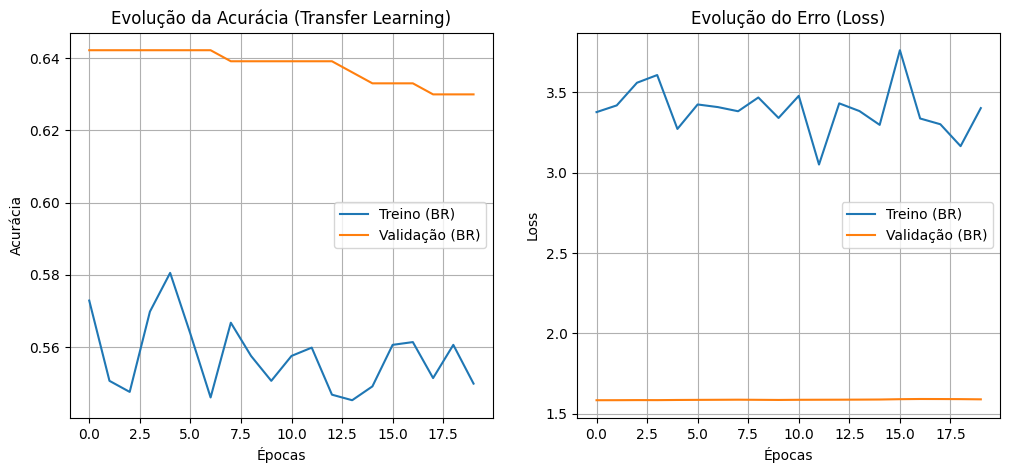


Gerando Matriz de Confusão no Dataset Brasileiro...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

--- Relatório de Classificação ---
              precision    recall  f1-score   support

           0       0.21      0.53      0.30        57
           1       0.90      0.14      0.24       270
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.21       327
   macro avg       0.22      0.13      0.11       327
weighted avg       0.78      0.21      0.25       327



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


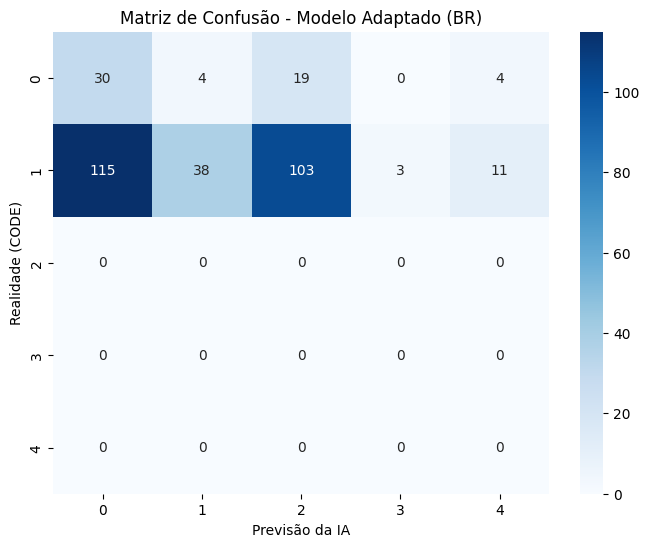

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# --- 1. Acurácia Final (Números) ---
acc_final_treino = history_br.history['accuracy'][-1] * 100
acc_final_validacao = history_br.history['val_accuracy'][-1] * 100

print(f"=== RESULTADO DO FINE-TUNING ===")
print(f"Acurácia Final no Treino:     {acc_final_treino:.2f}%")
print(f"Acurácia Final na Validação:  {acc_final_validacao:.2f}%")

# --- 2. Gráficos de Evolução (Para o TCC) ---
plt.figure(figsize=(12, 5))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(history_br.history['accuracy'], label='Treino (BR)')
plt.plot(history_br.history['val_accuracy'], label='Validação (BR)')
plt.title('Evolução da Acurácia (Transfer Learning)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

# Gráfico de Perda (Loss)
plt.subplot(1, 2, 2)
plt.plot(history_br.history['loss'], label='Treino (BR)')
plt.plot(history_br.history['val_loss'], label='Validação (BR)')
plt.title('Evolução do Erro (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# --- 3. Teste de Fogo (Matriz de Confusão) ---
print("\nGerando Matriz de Confusão no Dataset Brasileiro...")

# Fazer previsões no conjunto de teste brasileiro
y_pred_br = model.predict(X_test_br)
y_pred_classes_br = np.argmax(y_pred_br, axis=1)
y_true_classes_br = np.argmax(y_test_br, axis=1) # Se y_test_br for one-hot

# Relatório Detalhado
print("\n--- Relatório de Classificação ---")
# Ajuste os nomes das classes conforme o que você usou no y_br (Ex: 0=Normal, 1=Arritmia...)
print(classification_report(y_true_classes_br, y_pred_classes_br))

# Plotar a Matriz
cm = confusion_matrix(y_true_classes_br, y_pred_classes_br)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Modelo Adaptado (BR)')
plt.ylabel('Realidade (CODE)')
plt.xlabel('Previsão da IA')
plt.show()

In [ ]:
# --- REFAZENDO OS RÓTULOS PARA BINÁRIO (0 ou 1) ---
print("Gerando rótulos Binários (Saudável vs Doente)...")

y_br_binario = []
for index, row in df.iterrows():
    if row['normal_ecg']:
        y_br_binario.append(0) # 0 = Normal
    else:
        y_br_binario.append(1) # 1 = Alterado/Perigo

# Agora são apenas 2 classes!
y_br_cat = to_categorical(y_br_binario, num_classes=2)

# Dividir novamente
X_train_br, X_test_br, y_train_br, y_test_br = train_test_split(
    X_br, y_br_cat, test_size=0.2, stratify=y_br_binario, random_state=42
)

print(f"Novos dados prontos: {y_train_br.shape}") # Deve mostrar (N, 2) no final

Gerando rótulos Binários (Saudável vs Doente)...
Novos dados prontos: (1304, 2)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np

# 1. Carregar o modelo original (MIT)
base_model = tf.keras.models.load_model('modelo_ecg_final.keras')

print(f"Modelo original carregado com {len(base_model.layers)} camadas.")

# 2. CIRURGIA SEGURA (Copiando Camadas)
# Em vez de tentar converter o grafo, vamos criar um novo Sequential
model_br = Sequential()

# Copia todas as camadas do modelo antigo, MENOS a última (que é a de 5 saídas)
# layers[:-1] significa "do começo até o penúltimo"
for layer in base_model.layers[:-1]:
    model_br.add(layer)

# 3. Adicionar a NOVA camada de saída (2 neurônios: Normal vs Perigo)
# name='output_br' ajuda a identificar
model_br.add(Dense(2, activation='softmax', name='output_br'))

# 4. Descongelar para Fine-Tuning
# Vamos deixar as primeiras camadas (convoluções) congeladas para não perder o básico
# e treinar só as densas do final.
# (Ou se quiser treinar tudo, mude para True)
for layer in model_br.layers[:-2]: # Congela as convoluções
    layer.trainable = False
for layer in model_br.layers[-2:]: # Treina as Densas finais
    layer.trainable = True

print("Novo modelo Híbrido montado com sucesso!")
model_br.summary() # Mostra a nova estrutura

# 5. Compilar
model_br.compile(optimizer=Adam(learning_rate=1e-5),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# 6. Calcular Pesos (Balanceamento)
y_inteiros = np.argmax(y_train_br, axis=1)
pesos = class_weight.compute_class_weight('balanced', classes=np.unique(y_inteiros), y=y_inteiros)
pesos_dict = dict(zip(np.unique(y_inteiros), pesos))

print("Iniciando treino do Modelo Especialista Binário...")
history_br = model_br.fit(
    X_train_br, y_train_br,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_br, y_test_br),
    class_weight=pesos_dict
)

Modelo original carregado com 13 camadas.
Novo modelo Híbrido montado com sucesso!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 356, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 356, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 178, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 174, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 174, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 87, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 83, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 83, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 41, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5248)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       671,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_br (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 724,352 (2.76 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 724,352 (2.76 MB)

Iniciando treino do Modelo Especialista Binário...
Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5306 - loss: 4.0889 - val_accuracy: 0.5688 - val_loss: 2.1846
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5209 - loss: 3.9039 - val_accuracy: 0.5688 - val_loss: 2.1837
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5249 - loss: 4.9909 - val_accuracy: 0.5657 - val_loss: 2.1826
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5290 - loss: 4.2032 - val_accuracy: 0.5657 - val_loss: 2.1832
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5199 - loss: 4.4763 - val_accuracy: 0.5657 - val_loss: 2.1828
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5088 - loss: 4.2683 - val_accuracy: 0.5657 - val_loss: 2.1799
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5312 - loss: 3.8853 - val_accuracy: 0.5657 - val_loss: 2.1796
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accurac

In [ ]:
# --- BLOCO 1: PREPARAÇÃO BINÁRIA ---
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

print("1. Refazendo rótulos para Binário (Normal vs Alterado)...")

y_br_binario = []
#df é o seu dataframe do exams.csv
for index, row in df.iterrows():
    if row['normal_ecg']:
        y_br_binario.append(0) # Normal
    else:
        y_br_binario.append(1) # Alterado

# Garante que é array numpy
y_br_binario = np.array(y_br_binario)

# One-Hot Encoding para 2 classes
y_br_cat = to_categorical(y_br_binario, num_classes=2)

# Dividir (X_br já deve estar na memória das etapas anteriores)
X_train_br, X_test_br, y_train_br, y_test_br = train_test_split(
    X_br, y_br_cat, test_size=0.2, stratify=y_br_binario, random_state=42
)

# Calcular Pesos (Fundamental para o desbalanceamento)
y_ints = np.argmax(y_train_br, axis=1)
pesos = class_weight.compute_class_weight('balanced', classes=np.unique(y_ints), y=y_ints)
pesos_dict = dict(zip(np.unique(y_ints), pesos))

print(f"Dados Prontos! Treino: {X_train_br.shape}. Pesos: {pesos_dict}")

1. Refazendo rótulos para Binário (Normal vs Alterado)...
Dados Prontos! Treino: (1304, 360, 1). Pesos: {np.int64(0): np.float64(2.8471615720524017), np.int64(1): np.float64(0.6065116279069768)}


In [ ]:
# --- BLOCO 2: TREINAMENTO ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

print("2. Construindo Modelo Híbrido...")

# Carrega original
base_model = tf.keras.models.load_model('modelo_ecg_final.keras')

# Cria novo e copia camadas (Menos a última)
model_br = Sequential()
for layer in base_model.layers[:-1]:
    model_br.add(layer)

# Adiciona nova saída BINÁRIA (2 neurônios)
model_br.add(Dense(2, activation='softmax', name='output_br'))

# Descongela tudo para aprender bem
for layer in model_br.layers:
    layer.trainable = True

# Compila (Aumentei um pouco a Learning Rate para 0.0001 para aprender mais rápido)
model_br.compile(optimizer=Adam(learning_rate=1e-4),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

print("Treinando...")
history_br = model_br.fit(
    X_train_br, y_train_br,
    epochs=15,
    batch_size=32,
    validation_data=(X_test_br, y_test_br),
    class_weight=pesos_dict # Usa os pesos calculados no Bloco 1
)

2. Construindo Modelo Híbrido...
Treinando...
Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.6657 - loss: 11.8381 - val_accuracy: 0.6361 - val_loss: 2.4739
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.6384 - loss: 9.5931 - val_accuracy: 0.5963 - val_loss: 2.5788
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5892 - loss: 7.9837 - val_accuracy: 0.4128 - val_loss: 2.7771
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.5475 - loss: 6.9023 - val_accuracy: 0.4618 - val_loss: 2.5934
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.5638 - loss: 5.4896 - val_accuracy: 0.3976 - val_loss: 2.7800
Epoch 6/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.5374 - loss: 5.5015 - val_accuracy: 0.4526 - val_loss: 2.5822
Epoch 7/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.5346 - loss: 6.0143 - val_accuracy: 0.4740 - val_loss: 2.4666
Epoch 8/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy

a acurácia está caindo a cada época (em vez de subir), está acontecendo um fenômeno chamado "Esquecimento Catastrófico" (Catastrophic Forgetting).

Basicamente, o modelo está tentando aprender os dados novos (Brasil) tão rápido que está "destruindo" tudo o que ele aprendeu com os dados antigos (MIT). Ele está "desaprendendo" a ler ECGs.

3. Avaliando Resultados...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
              precision    recall  f1-score   support

      Normal       0.20      0.67      0.30        57
    Alterado       0.86      0.42      0.57       270

    accuracy                           0.46       327
   macro avg       0.53      0.54      0.43       327
weighted avg       0.74      0.46      0.52       327



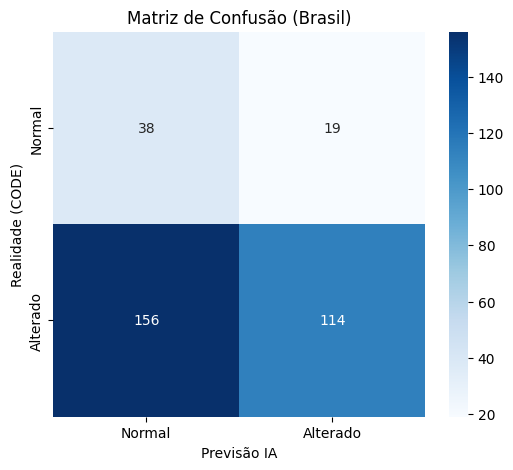

In [ ]:
# --- BLOCO 3: AVALIAÇÃO BINÁRIA ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("3. Avaliando Resultados...")

# Previsão
y_pred = model_br.predict(X_test_br)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_br, axis=1)

# Relatório (Agora só com Normal e Alterado)
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Alterado']))

# Matriz
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Alterado'], yticklabels=['Normal', 'Alterado'])
plt.ylabel('Realidade (CODE)')
plt.xlabel('Previsão IA')
plt.title('Matriz de Confusão (Brasil)')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

print("--- INICIANDO ESTRATÉGIA DE 2 FASES ---")

# 1. Carregar Modelo Original
base_model = tf.keras.models.load_model('modelo_ecg_final.keras')

# 2. Montar Nova Estrutura
model_br = Sequential()
for layer in base_model.layers[:-1]: # Copia tudo menos a última
    model_br.add(layer)

# Adiciona a nova cabeça (Binária)
model_br.add(Dense(2, activation='softmax', name='output_br'))

# ==========================================
# FASE 1: TREINAR APENAS A CABEÇA (Warm-up)
# ==========================================
print("\n🔥 FASE 1: Treinando apenas a camada final (Congelando o resto)...")

# Congela todas as camadas antigas
for layer in model_br.layers[:-1]:
    layer.trainable = False

# Compila (LR normal aqui é ok, pois só mexe no final)
model_br.compile(optimizer=Adam(learning_rate=1e-3),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Treina por poucas épocas só para ajustar os pesos finais
model_br.fit(
    X_train_br, y_train_br,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_br, y_test_br),
    class_weight=pesos_dict,
    verbose=1
)

# ==========================================
# FASE 2: FINE-TUNING (Ajuste Fino)
# ==========================================
print("\n❄️ FASE 2: Descongelando tudo com Learning Rate MINÚSCULA...")

# Descongela tudo
for layer in model_br.layers:
    layer.trainable = True

# Compila com LR MUITO BAIXA (1e-5 ou 1e-6)
# Isso garante que ele só faça micro-ajustes sem quebrar o conhecimento
model_br.compile(optimizer=Adam(learning_rate=1e-5),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Treina pra valer
history_br = model_br.fit(
    X_train_br, y_train_br,
    epochs=15,
    batch_size=32,
    validation_data=(X_test_br, y_test_br),
    class_weight=pesos_dict
)

print("Treinamento Inteligente Concluído!")

--- INICIANDO ESTRATÉGIA DE 2 FASES ---

🔥 FASE 1: Treinando apenas a camada final (Congelando o resto)...
Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.5072 - loss: 3.9026 - val_accuracy: 0.5107 - val_loss: 2.1765
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4598 - loss: 3.4288 - val_accuracy: 0.4862 - val_loss: 2.0257
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4844 - loss: 3.3472 - val_accuracy: 0.4618 - val_loss: 1.9678
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5048 - loss: 2.7480 - val_accuracy: 0.4679 - val_loss: 1.6854
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4912 - loss: 2.4735 - val_accuracy: 0.4954 - val_loss: 1.4256

❄️ FASE 2: Descongelando tudo com Learning Rate MINÚSCULA...
Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.4126 - loss: 6.9481 - val_accuracy: 0.5138 - val_loss: 1.6317
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.4489 - lo

=== DIAGNÓSTICO DOS DADOS ===
Minimo do X: 0.0000
Maximo do X: 1.0000
Média do X:  0.5279
✅ Normalização parece OK.

Contagem de Classes no Treino:
Classe 0 (Normal):   229
Classe 1 (Alterado): 1075


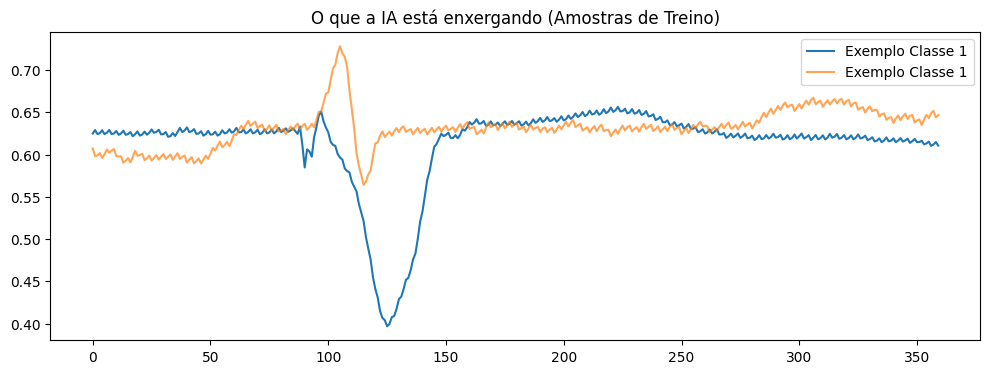

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print("=== DIAGNÓSTICO DOS DADOS ===")

# 1. Verificar Intervalo de Valores (Normalização)
print(f"Minimo do X: {np.min(X_train_br):.4f}")
print(f"Maximo do X: {np.max(X_train_br):.4f}")
print(f"Média do X:  {np.mean(X_train_br):.4f}")

if np.max(X_train_br) > 1.5 or np.min(X_train_br) < -0.5:
    print("⚠️ ALERTA: Os dados parecem não estar normalizados entre 0 e 1!")
else:
    print("✅ Normalização parece OK.")

# 2. Verificar Balanceamento das Classes
contagem = np.sum(y_train_br, axis=0)
print(f"\nContagem de Classes no Treino:")
print(f"Classe 0 (Normal):   {int(contagem[0])}")
print(f"Classe 1 (Alterado): {int(contagem[1])}")

# 3. Visualizar o que a rede vê
plt.figure(figsize=(12, 4))
plt.plot(X_train_br[0], label=f"Exemplo Classe {np.argmax(y_train_br[0])}")
plt.plot(X_train_br[1], label=f"Exemplo Classe {np.argmax(y_train_br[1])}", alpha=0.7)
plt.title("O que a IA está enxergando (Amostras de Treino)")
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# --- REDE DEDICADA BRASIL (Simples e Eficiente) ---
model_br_nativa = Sequential([
    # Camada 1
    Conv1D(32, 5, activation='relu', input_shape=(X_train_br.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(2),

    # Camada 2
    Conv1D(64, 5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    # Camada 3
    Conv1D(128, 5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Flatten(),

    Dense(64, activation='relu'),
    Dropout(0.5), # Evita decorar

    Dense(2, activation='softmax') # Binário: Normal vs Doente
])

model_br_nativa.compile(optimizer=Adam(learning_rate=0.001), # LR normal para treino do zero
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

print("Treinando Rede Brasileira do Zero...")
history_br = model_br_nativa.fit(
    X_train_br, y_train_br,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_br, y_test_br),
    class_weight=pesos_dict
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Treinando Rede Brasileira do Zero...
Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.5285 - loss: 3.4097 - val_accuracy: 0.8257 - val_loss: 0.6558
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.5793 - loss: 3.8627 - val_accuracy: 0.1743 - val_loss: 1.7278
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.5449 - loss: 3.1033 - val_accuracy: 0.8257 - val_loss: 0.4695
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5513 - loss: 2.1127 - val_accuracy: 0.8257 - val_loss: 0.5638
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.5640 - loss: 2.0174 - val_accuracy: 0.8257 - val_loss: 0.4737
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.5624 - loss: 1.5571 - val_accuracy: 0.8257 - val_loss: 0.4623
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5609 - loss: 1.2035 - val_accuracy: 0.8257 - val_loss: 0.5598
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.5522 - l

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("--- INICIANDO TREINAMENTO DA REDE NATIVA (DO ZERO) ---")

# 1. Arquitetura Otimizada para ECG (Leve e Eficiente)
# Usamos GlobalAveragePooling no final para reduzir overfitting
model_br_nativa = Sequential([
    # Bloco 1
    Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(360, 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Bloco 2
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Bloco 3
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Camada de Adaptação Global (Melhor que Flatten para séries temporais)
    GlobalAveragePooling1D(),

    # Classificador
    Dense(64, activation='relu'),
    Dropout(0.5), # Desliga 50% dos neurônios para forçar aprendizado robusto

    # Saída Binária (0=Normal, 1=Alterado)
    Dense(2, activation='softmax')
])

# 2. Callbacks (Inteligência de Treino)
# Para se não melhorar e reduz a velocidade se empacar
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss')
]

# 3. Compilar
model_br_nativa.compile(optimizer=Adam(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# 4. Treinar
history_br = model_br_nativa.fit(
    X_train_br, y_train_br,
    epochs=50, # Pode colocar bastante, o EarlyStopping para antes se precisar
    batch_size=32,
    validation_data=(X_test_br, y_test_br),
    class_weight=pesos_dict, # Fundamental para as classes desbalanceadas
    callbacks=callbacks
)

# 5. Avaliação Final
print("\n--- AVALIAÇÃO FINAL ---")
loss, acc = model_br_nativa.evaluate(X_test_br, y_test_br)
print(f"Acurácia no Teste: {acc*100:.2f}%")

--- INICIANDO TREINAMENTO DA REDE NATIVA (DO ZERO) ---
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - accuracy: 0.5388 - loss: 0.9767 - val_accuracy: 0.1743 - val_loss: 0.7091 - learning_rate: 0.0010
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.5189 - loss: 0.7718 - val_accuracy: 0.1743 - val_loss: 0.7461 - learning_rate: 0.0010
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.5058 - loss: 0.7059 - val_accuracy: 0.1743 - val_loss: 0.7290 - learning_rate: 0.0010
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.5337 - loss: 0.7730 - val_accuracy: 0.3303 - val_loss: 0.6983 - learning_rate: 0.0010
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.6140 - loss: 0.7096 - val_accuracy: 0.7676 - val_loss: 0.6495 - learning_rate: 0.0010
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5079 - loss: 0.7210 - val_accuracy: 0.7798 - val_loss: 0.6329 - learning_rate: 0.0010
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━

3. Avaliando Resultados...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

      Normal       0.20      0.67      0.30        57
    Alterado       0.86      0.42      0.57       270

    accuracy                           0.46       327
   macro avg       0.53      0.54      0.43       327
weighted avg       0.74      0.46      0.52       327



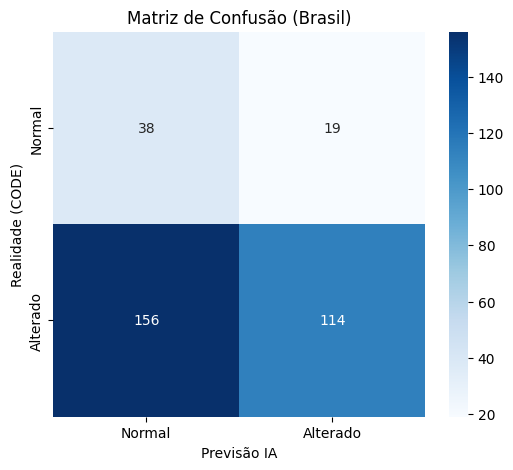

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("3. Avaliando Resultados...")

# Previsão
y_pred = model_br.predict(X_test_br)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_br, axis=1)

# Relatório (Agora só com Normal e Alterado)
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Alterado']))

# Matriz
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Alterado'], yticklabels=['Normal', 'Alterado'])
plt.ylabel('Realidade (CODE)')
plt.xlabel('Previsão IA')
plt.title('Matriz de Confusão (Brasil)')
plt.show()

In [ ]:
import tensorflow as tf
import os

print("--- CONVERTENDO O MODELO BRASILEIRO ---")

# 1. Salvar o modelo Keras (Backup)
model_br_nativa.save('modelo_ecg_brasil.keras')

# 2. Converter para TFLite (Otimizado)
converter = tf.lite.TFLiteConverter.from_keras_model(model_br_nativa)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# (Opcional) Se quiser garantir compatibilidade total, não usamos int8 forçado aqui
# para evitar erros de versão, vamos usar a otimização padrão que já reduz bem.
tflite_model_br = converter.convert()

# 3. Salvar o arquivo .tflite
filename = 'model_br_nativa.tflite'
with open(filename, 'wb') as f:
    f.write(tflite_model_br)

print(f"✅ Sucesso! Arquivo gerado: {filename}")
print(f"Tamanho: {os.path.getsize(filename) / 1024:.2f} KB")

# 4. Baixar para o seu PC
from google.colab import files
files.download(filename)

--- CONVERTENDO O MODELO BRASILEIRO ---
Saved artifact at '/tmp/tmpmrhcuxg7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 360, 1), dtype=tf.float32, name='keras_tensor_708')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133791111681360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111681168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111680400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111683280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111683088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111680976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111682320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111679248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111683664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111680016: TensorSpec(shape=(), dtype=t

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
from google.colab import files

print("🔄 Gerando Modelo Compatível (Float32 Input)...")

# 1. Configurar conversor
converter = tf.lite.TFLiteConverter.from_keras_model(model_br_nativa)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 2. O SEGREDO: Forçar entrada e saída a serem FLOAT32 (mesmo com pesos comprimidos)
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# 3. Converter
tflite_model_compatible = converter.convert()

# 4. Salvar com o MESMO NOME para não ter que mexer no Android
nome_arquivo = 'model_br_nativa.tflite'

with open(nome_arquivo, 'wb') as f:
    f.write(tflite_model_compatible)

print(f"✅ Modelo gerado! Tamanho esperado: ~{len(tflite_model_compatible)/1024:.1f} KB")

# 5. Baixar
files.download(nome_arquivo)

🔄 Gerando Modelo Compatível (Float32 Input)...
Saved artifact at '/tmp/tmploesdzp0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 360, 1), dtype=tf.float32, name='keras_tensor_708')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133791111681360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111681168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111680400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111683280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111683088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111680976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111682320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111679248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111683664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111680016: TensorSpec(shape=(), 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
from google.colab import files
import os

print("🔄 Gerando Modelo Padrão (FLOAT32 PURO)...")

# 1. Configurar conversor SEM otimizações
# Isso garante que ele mantenha os tipos originais (Float)
converter = tf.lite.TFLiteConverter.from_keras_model(model_br_nativa)

# converter.optimizations = [tf.lite.Optimize.DEFAULT]  <-- COMENTEI ESSA LINHA PROPOSITALMENTE

# 2. Converter
tflite_model_float = converter.convert()

# 3. Salvar
# Vamos usar o MESMO NOME para você não precisar mudar o código Android
nome_arquivo = 'model_br_nativa.tflite'

with open(nome_arquivo, 'wb') as f:
    f.write(tflite_model_float)

print(f"✅ Modelo Float32 gerado!")
print(f"Tamanho: {os.path.getsize(nome_arquivo) / 1024:.2f} KB (Deve ser maior que o anterior)")

# 4. Baixar
files.download(nome_arquivo)

🔄 Gerando Modelo Padrão (FLOAT32 PURO)...
Saved artifact at '/tmp/tmps5bxz_t2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 360, 1), dtype=tf.float32, name='keras_tensor_708')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133791111681360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111681168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111680400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111683280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111683088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111680976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111682320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111679248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111683664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791111680016: TensorSpec(shape=(), dtype

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>